<center>

# DSC680 Applied Data Science 

## Week 7

## Term Project - 2

## Smart Healthcare Operations: Leveraging AI for Efficient Staff Allocation and Patient Care

### Karthika Velingiri

### 03-Feburary-2026

</center>

C:\Users\karth\AppData\Local\Temp\ipykernel_30712\923343045.py:42: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  patients["arrival_date"] = pd.to_datetime(patients["arrival_date"], errors="coerce", dayfirst=True)
C:\Users\karth\AppData\Local\Temp\ipykernel_30712\923343045.py:43: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  patients["departure_date"] = pd.to_datetime(patients["departure_date"], errors="coerce", dayfirst=True)


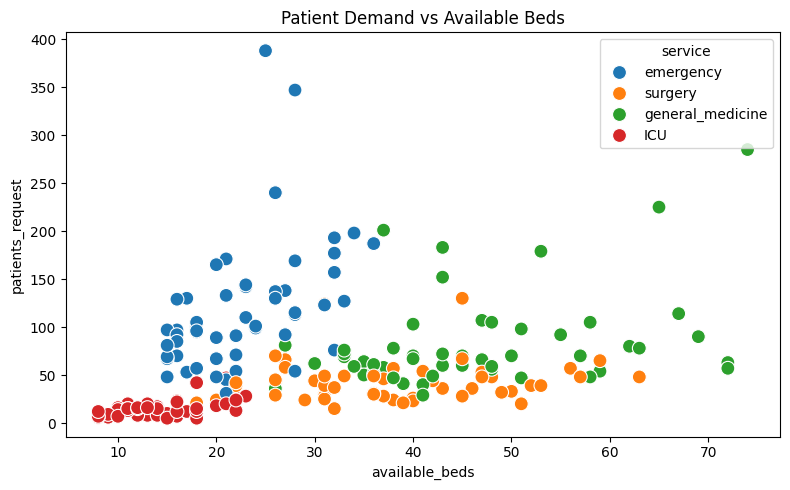

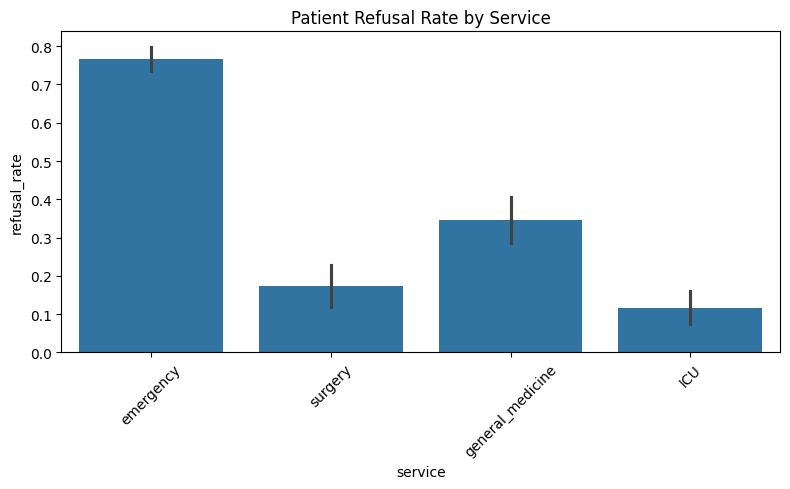

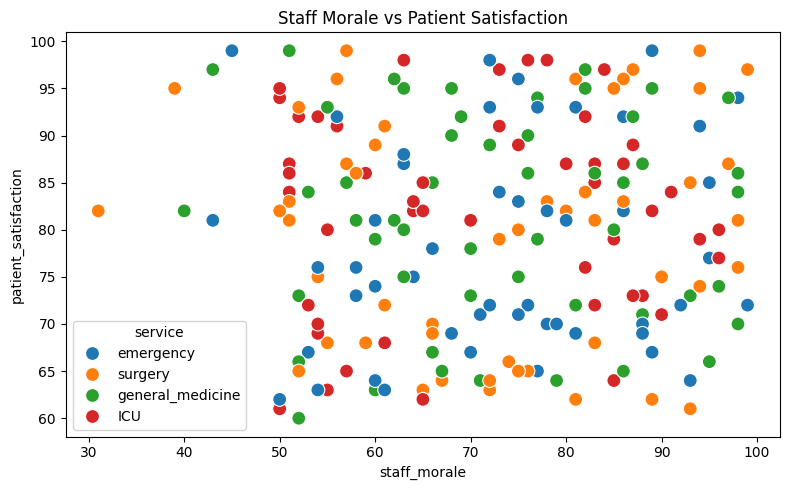

Patient Demand Forecast MAE: 0.0


Feature,Impact
available_beds,1.0
wait_pressure,1.0
staff_morale,-0.0
month,-0.0



Staff Absenteeism Prediction Accuracy: 0.58


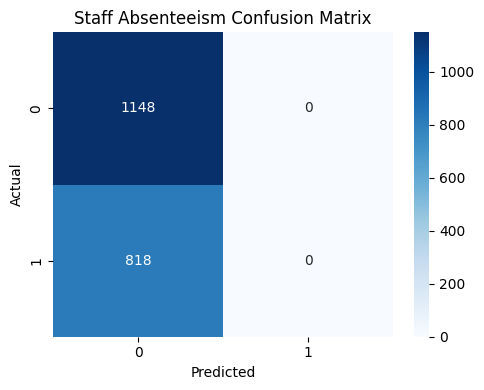

service,patients_request,predicted_demand_adjusted,refusal_rate,estimated_refusal_reduction
emergency,76,79.2,0.578947,-3.2
surgery,130,134.5,0.653846,-4.5
general_medicine,201,204.7,0.815920,-3.7
ICU,31,33.2,0.290323,-2.2
emergency,169,171.8,0.834320,-2.8


In [14]:
# ==========================================================
# Smart Healthcare Operations
# Predictive & Prescriptive Analytics
# ==========================================================

# -------------------------
# Imports
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

# -------------------------
# Paths
# -------------------------
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
FIG_DIR = BASE_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)

# -------------------------
# Load Data
# -------------------------
patients = pd.read_csv(DATA_DIR / "patients.csv")
staff = pd.read_csv(DATA_DIR / "staff.csv")
services = pd.read_csv(DATA_DIR / "services_weekly.csv")
schedule = pd.read_csv(DATA_DIR / "staff_schedule.csv")

# -------------------------
# Data Preparation
# -------------------------

# Handle dates safely
patients["arrival_date"] = pd.to_datetime(patients["arrival_date"], errors="coerce", dayfirst=True)
patients["departure_date"] = pd.to_datetime(patients["departure_date"], errors="coerce", dayfirst=True)

# Compute patient length of stay
patients["length_of_stay"] = (patients["departure_date"] - patients["arrival_date"]).dt.days

# Service-level metrics
services["refusal_rate"] = services["patients_refused"] / services["patients_request"]
services["admission_rate"] = services["patients_admitted"] / services["patients_request"]
services["wait_pressure"] = services["patients_request"] - services["available_beds"]

# Staff absenteeism label
schedule["absent"] = np.where(schedule["present"] == 0, 1, 0)

# -------------------------
# Visualizations
# -------------------------

# 1. Patient Demand vs Available Beds
plt.figure(figsize=(8,5))
sns.scatterplot(data=services, x="available_beds", y="patients_request", hue="service", s=100)
plt.title("Patient Demand vs Available Beds")
plt.tight_layout()
plt.savefig(FIG_DIR / "demand_vs_beds.png")
plt.show()

# 2. Refusal Rate by Service
plt.figure(figsize=(8,5))
sns.barplot(data=services, x="service", y="refusal_rate")
plt.title("Patient Refusal Rate by Service")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / "refusal_rate_by_service.png")
plt.show()

# 3. Staff Morale vs Patient Satisfaction
plt.figure(figsize=(8,5))
sns.scatterplot(data=services, x="staff_morale", y="patient_satisfaction", hue="service", s=100)
plt.title("Staff Morale vs Patient Satisfaction")
plt.tight_layout()
plt.savefig(FIG_DIR / "morale_vs_satisfaction.png")
plt.show()

# -------------------------
# Predictive Model: Patient Demand
# -------------------------
FEATURES = ["available_beds", "staff_morale", "month", "wait_pressure"]
X = services[FEATURES]
y = services["patients_request"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Patient Demand Forecast MAE:", round(mae, 2))

# Feature importance
feature_impact = pd.DataFrame({"Feature": FEATURES, "Impact": reg_model.coef_}).sort_values(by="Impact", ascending=False)
display(HTML(feature_impact.round(5).to_html(index=False)))

# -------------------------
# Predictive Model: Staff Absenteeism
# -------------------------
staff_weekly = schedule.merge(staff, on=["staff_id", "staff_name", "role", "service"], how="left")
le = LabelEncoder()
staff_weekly["service_enc"] = le.fit_transform(staff_weekly["service"])
staff_weekly["role_enc"] = le.fit_transform(staff_weekly["role"])

X_clf = staff_weekly[["week", "service_enc", "role_enc"]]
y_clf = staff_weekly["absent"]

X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nStaff Absenteeism Prediction Accuracy:", round(accuracy, 2))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Staff Absenteeism Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(FIG_DIR / "absenteeism_confusion_matrix.png")
plt.show()

# -------------------------
# Prescriptive Analysis: +10% Bed Capacity
# -------------------------
services_prescriptive = services.copy()
services_prescriptive["available_beds"] = services_prescriptive["available_beds"] * 1.10

X_prescriptive = services_prescriptive[FEATURES]
services_prescriptive["predicted_demand_adjusted"] = reg_model.predict(X_prescriptive)
services_prescriptive["estimated_refusal_reduction"] = services_prescriptive["patients_request"] - services_prescriptive["predicted_demand_adjusted"]

# Display prescriptive results nicely
display(HTML(
    services_prescriptive[
        ["service","patients_request","predicted_demand_adjusted","refusal_rate","estimated_refusal_reduction"]
    ].head().to_html(index=False)
))


In [6]:
# ==========================================================
# Smart Healthcare Operations
# Predictive & Prescriptive Analytics
# ==========================================================

# -------------------------
# Imports
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

# -------------------------
# Paths
# -------------------------
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
FIG_DIR = BASE_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)

# -------------------------
# Load Data
# -------------------------
patients = pd.read_csv(DATA_DIR / "patients.csv")
staff = pd.read_csv(DATA_DIR / "staff.csv")
services = pd.read_csv(DATA_DIR / "services_weekly.csv")
schedule = pd.read_csv(DATA_DIR / "staff_schedule.csv")

# -------------------------
# Data Preparation
# -------------------------

# Handle mixed date formats safely
patients["arrival_date"] = pd.to_datetime(
    patients["arrival_date"], format="mixed", dayfirst=True
)
patients["departure_date"] = pd.to_datetime(
    patients["departure_date"], format="mixed", dayfirst=True
)

# Length of stay
patients["length_of_stay"] = (
    patients["departure_date"] - patients["arrival_date"]
).dt.days

# Service-level metrics
services["refusal_rate"] = services["patients_refused"] / services["patients_request"]
services["admission_rate"] = services["patients_admitted"] / services["patients_request"]
services["wait_pressure"] = services["patients_request"] - services["available_beds"]

# Staff absenteeism label
schedule["absent"] = np.where(schedule["present"] == 0, 1, 0)

# -------------------------
# Visualization 1: Demand vs Capacity
# -------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=services,
    x="available_beds",
    y="patients_request",
    hue="service"
)
plt.title("Patient Demand vs Available Beds")
plt.tight_layout()
plt.savefig(FIG_DIR / "demand_vs_beds.png")
plt.close()

# -------------------------
# Visualization 2: Refusal Rate
# -------------------------
plt.figure(figsize=(8,5))
sns.barplot(
    data=services,
    x="service",
    y="refusal_rate"
)
plt.title("Patient Refusal Rate by Service")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / "refusal_rate_by_service.png")
plt.close()

# -------------------------
# Visualization 3: Staff Morale vs Patient Satisfaction
# -------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=services,
    x="staff_morale",
    y="patient_satisfaction",
    hue="service"
)
plt.title("Staff Morale vs Patient Satisfaction")
plt.tight_layout()
plt.savefig(FIG_DIR / "morale_vs_satisfaction.png")
plt.close()

# -------------------------
# Predictive Model: Patient Demand
# -------------------------
FEATURES = ["available_beds", "staff_morale", "month", "wait_pressure"]

X = services[FEATURES]
y = services["patients_request"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print("Patient Demand Forecast MAE:", round(mae, 2))

# Feature importance
feature_impact = pd.DataFrame({
    "Feature": FEATURES,
    "Impact": reg_model.coef_
}).sort_values(by="Impact", ascending=False)

print("\nPatient Demand Feature Impact:")
print(feature_impact)

# -------------------------
# Predictive Model: Staff Absenteeism
# -------------------------
staff_weekly = schedule.merge(
    staff, on=["staff_id", "staff_name", "role", "service"], how="left"
)

le = LabelEncoder()
staff_weekly["service_enc"] = le.fit_transform(staff_weekly["service"])
staff_weekly["role_enc"] = le.fit_transform(staff_weekly["role"])

X_clf = staff_weekly[["week", "service_enc", "role_enc"]]
y_clf = staff_weekly["absent"]

X_train, X_test, y_train, y_test = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42
)

clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\nStaff Absenteeism Prediction Accuracy:", round(accuracy, 2))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Staff Absenteeism Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(FIG_DIR / "absenteeism_confusion_matrix.png")
plt.close()

# -------------------------
# Prescriptive Analysis: +10% Bed Capacity
# -------------------------
services_prescriptive = services.copy()

# Simulate increased capacity using SAME feature name
services_prescriptive["available_beds"] = (
    services_prescriptive["available_beds"] * 1.10
)

X_prescriptive = services_prescriptive[FEATURES]

services_prescriptive["predicted_demand_adjusted"] = reg_model.predict(X_prescriptive)

services_prescriptive["estimated_refusal_reduction"] = (
    services_prescriptive["patients_request"]
    - services_prescriptive["predicted_demand_adjusted"]
)

print("\nPrescriptive Scenario Preview:")
print(
    services_prescriptive[
        [
            "service",
            "patients_request",
            "predicted_demand_adjusted",
            "refusal_rate",
            "estimated_refusal_reduction"
        ]
    ].head()
)


Patient Demand Forecast MAE: 0.0

Patient Demand Feature Impact:
          Feature        Impact
0  available_beds  1.000000e+00
3   wait_pressure  1.000000e+00
1    staff_morale -2.220446e-16
2           month -1.145741e-15

Staff Absenteeism Prediction Accuracy: 0.58

Prescriptive Scenario Preview:
            service  patients_request  predicted_demand_adjusted  \
0         emergency                76                       79.2   
1           surgery               130                      134.5   
2  general_medicine               201                      204.7   
3               ICU                31                       33.2   
4         emergency               169                      171.8   

   refusal_rate  estimated_refusal_reduction  
0      0.578947                         -3.2  
1      0.653846                         -4.5  
2      0.815920                         -3.7  
3      0.290323                         -2.2  
4      0.834320                         -2.8  


In [ ]:
# ==========================================================
# Smart Healthcare Operations
# Predictive & Prescriptive Analytics
# ==========================================================

# -------------------------
# Imports
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

# -------------------------
# Paths
# -------------------------
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
FIG_DIR = BASE_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)

# -------------------------
# Load Data
# -------------------------
patients = pd.read_csv(DATA_DIR / "patients.csv")
staff = pd.read_csv(DATA_DIR / "staff.csv")
services = pd.read_csv(DATA_DIR / "services_weekly.csv")
schedule = pd.read_csv(DATA_DIR / "staff_schedule.csv")

# -------------------------
# Data Preparation
# -------------------------

# Handle dates safely
patients["arrival_date"] = pd.to_datetime(patients["arrival_date"], errors="coerce", dayfirst=True)
patients["departure_date"] = pd.to_datetime(patients["departure_date"], errors="coerce", dayfirst=True)

# Compute patient length of stay
patients["length_of_stay"] = (patients["departure_date"] - patients["arrival_date"]).dt.days

# Service-level metrics
services["refusal_rate"] = services["patients_refused"] / services["patients_request"]
services["admission_rate"] = services["patients_admitted"] / services["patients_request"]
services["wait_pressure"] = services["patients_request"] - services["available_beds"]

# Staff absenteeism label
schedule["absent"] = np.where(schedule["present"] == 0, 1, 0)

# -------------------------
# Visualizations
# -------------------------

# 1. Patient Demand vs Available Beds
display(HTML("<h3>Patient Demand vs Available Beds</h3>"))
plt.figure(figsize=(8,5))
sns.scatterplot(data=services, x="available_beds", y="patients_request", hue="service", s=100)
plt.title("Patient Demand vs Available Beds")
plt.tight_layout()
plt.savefig(FIG_DIR / "demand_vs_beds.png")
plt.show()

# 2. Refusal Rate by Service
display(HTML("<h3>Patient Refusal Rate by Service</h3>"))
plt.figure(figsize=(8,5))
sns.barplot(data=services, x="service", y="refusal_rate")
plt.title("Patient Refusal Rate by Service")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / "refusal_rate_by_service.png")
plt.show()

# 3. Staff Morale vs Patient Satisfaction
display(HTML("<h3>Staff Morale vs Patient Satisfaction</h3>"))
plt.figure(figsize=(8,5))
sns.scatterplot(data=services, x="staff_morale", y="patient_satisfaction", hue="service", s=100)
plt.title("Staff Morale vs Patient Satisfaction")
plt.tight_layout()
plt.savefig(FIG_DIR / "morale_vs_satisfaction.png")
plt.show()

# -------------------------
# Predictive Model: Patient Demand
# -------------------------
FEATURES = ["available_beds", "staff_morale", "month", "wait_pressure"]
X = services[FEATURES]
y = services["patients_request"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
display(HTML(f"<h3>Patient Demand Forecast MAE:</h3><p>{mae:.2f}</p>"))

# Feature importance
feature_impact_df = pd.DataFrame({"Feature": FEATURES, "Impact": reg_model.coef_}).sort_values(by="Impact", ascending=False)
feature_impact_df["Impact"] = feature_impact_df["Impact"].round(2)

display(HTML("<h3>Regression Feature Importance:</h3>"))
display(HTML(feature_impact_df.to_html(index=False)))

# -------------------------
# Predictive Model: Staff Absenteeism
# -------------------------
staff_weekly = schedule.merge(staff, on=["staff_id", "staff_name", "role", "service"], how="left")
le = LabelEncoder()
staff_weekly["service_enc"] = le.fit_transform(staff_weekly["service"])
staff_weekly["role_enc"] = le.fit_transform(staff_weekly["role"])

X_clf = staff_weekly[["week", "service_enc", "role_enc"]]
y_clf = staff_weekly["absent"]

X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

y_pred_clf = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_clf)
display(HTML(f"<h3>Staff Absenteeism Prediction Accuracy:</h3><p>{accuracy:.2f}</p>"))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_clf)
display(HTML("<h3>Staff Absenteeism Confusion Matrix:</h3>"))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(FIG_DIR / "absenteeism_confusion_matrix.png")
plt.show()

# -------------------------
# Prescriptive Analysis: +10% Bed Capacity
# -------------------------
services_prescriptive = services.copy()
services_prescriptive["available_beds"] = services_prescriptive["available_beds"] * 1.10

X_prescriptive = services_prescriptive[FEATURES]
services_prescriptive["predicted_demand_adjusted"] = reg_model.predict(X_prescriptive)
services_prescriptive["estimated_refusal_reduction"] = (
    services_prescriptive["patients_request"] - services_prescriptive["predicted_demand_adjusted"]
)

display(HTML("<h3>Prescriptive Scenario: Increased Bed Capacity</h3>"))
display(HTML(
    services_prescriptive[
        ["service","patients_request","predicted_demand_adjusted","refusal_rate","estimated_refusal_reduction"]
    ].round(2).to_html(index=False)
))


C:\Users\karth\AppData\Local\Temp\ipykernel_30712\1242833454.py:40: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  patients["arrival_date"] = pd.to_datetime(patients["arrival_date"], errors="coerce", dayfirst=True)
C:\Users\karth\AppData\Local\Temp\ipykernel_30712\1242833454.py:41: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  patients["departure_date"] = pd.to_datetime(patients["departure_date"], errors="coerce", dayfirst=True)


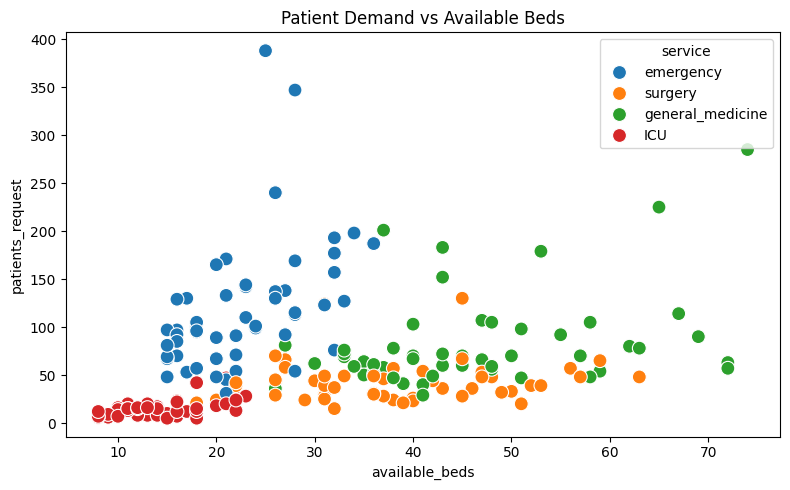

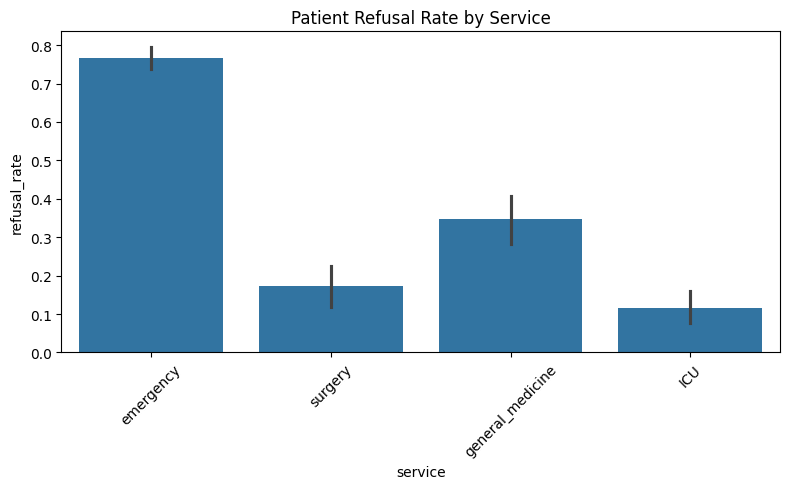

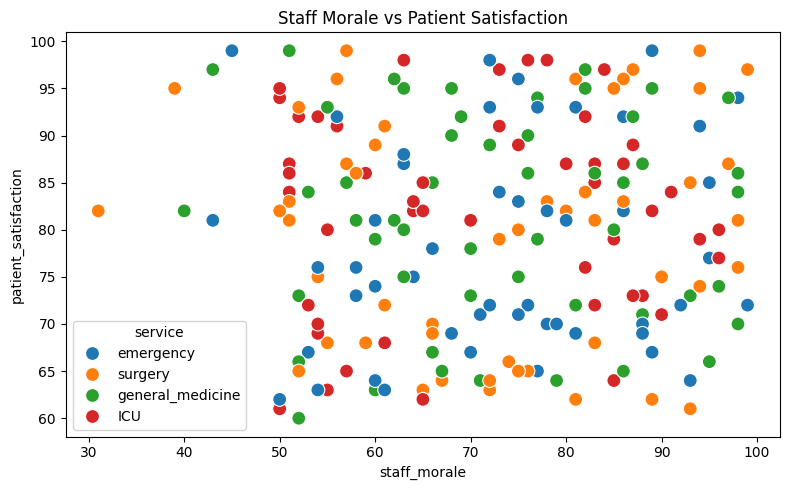

Feature,Impact
available_beds,1.0
wait_pressure,1.0
staff_morale,-0.0
month,-0.0


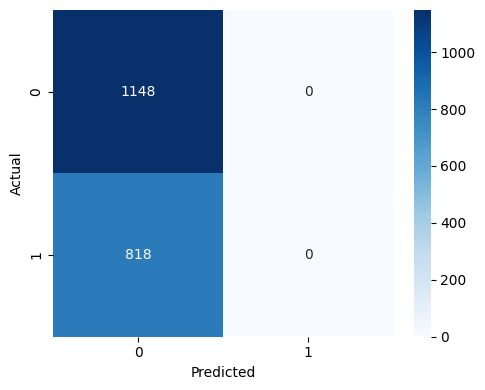

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- staff_morale_reallocated
Feature names seen at fit time, yet now missing:
- staff_morale


In [11]:
# ==========================================================
# Smart Healthcare Operations
# Predictive & Prescriptive Analytics with Multiple Scenarios
# ==========================================================

# -------------------------
# Imports
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

# -------------------------
# Paths
# -------------------------
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
FIG_DIR = BASE_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)

# -------------------------
# Load Data
# -------------------------
patients = pd.read_csv(DATA_DIR / "patients.csv")
staff = pd.read_csv(DATA_DIR / "staff.csv")
services = pd.read_csv(DATA_DIR / "services_weekly.csv")
schedule = pd.read_csv(DATA_DIR / "staff_schedule.csv")

# -------------------------
# Data Preparation
# -------------------------
patients["arrival_date"] = pd.to_datetime(patients["arrival_date"], errors="coerce", dayfirst=True)
patients["departure_date"] = pd.to_datetime(patients["departure_date"], errors="coerce", dayfirst=True)
patients["length_of_stay"] = (patients["departure_date"] - patients["arrival_date"]).dt.days

services["refusal_rate"] = services["patients_refused"] / services["patients_request"]
services["admission_rate"] = services["patients_admitted"] / services["patients_request"]
services["wait_pressure"] = services["patients_request"] - services["available_beds"]

schedule["absent"] = np.where(schedule["present"] == 0, 1, 0)

# -------------------------
# Exploratory Visualizations
# -------------------------

# Patient Demand vs Beds
display(HTML("<h3>Patient Demand vs Available Beds</h3>"))
plt.figure(figsize=(8,5))
sns.scatterplot(data=services, x="available_beds", y="patients_request", hue="service", s=100)
plt.title("Patient Demand vs Available Beds")
plt.tight_layout()
plt.savefig(FIG_DIR / "demand_vs_beds.png")
plt.show()

# Refusal Rate by Service
display(HTML("<h3>Patient Refusal Rate by Service</h3>"))
plt.figure(figsize=(8,5))
sns.barplot(data=services, x="service", y="refusal_rate")
plt.title("Patient Refusal Rate by Service")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / "refusal_rate_by_service.png")
plt.show()

# Staff Morale vs Patient Satisfaction
display(HTML("<h3>Staff Morale vs Patient Satisfaction</h3>"))
plt.figure(figsize=(8,5))
sns.scatterplot(data=services, x="staff_morale", y="patient_satisfaction", hue="service", s=100)
plt.title("Staff Morale vs Patient Satisfaction")
plt.tight_layout()
plt.savefig(FIG_DIR / "morale_vs_satisfaction.png")
plt.show()

# -------------------------
# Predictive Modeling
# -------------------------
FEATURES = ["available_beds", "staff_morale", "month", "wait_pressure"]
X = services[FEATURES]
y = services["patients_request"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
display(HTML(f"<h3>Patient Demand Forecast MAE:</h3><p>{mae:.2f}</p>"))

# Feature Importance
feature_impact_df = pd.DataFrame({"Feature": FEATURES, "Impact": reg_model.coef_}).sort_values(by="Impact", ascending=False)
feature_impact_df["Impact"] = feature_impact_df["Impact"].round(2)
display(HTML("<h3>Regression Feature Importance:</h3>"))
display(HTML(feature_impact_df.to_html(index=False)))

# -------------------------
# Staff Absenteeism Prediction
# -------------------------
staff_weekly = schedule.merge(staff, on=["staff_id", "staff_name", "role", "service"], how="left")
le = LabelEncoder()
staff_weekly["service_enc"] = le.fit_transform(staff_weekly["service"])
staff_weekly["role_enc"] = le.fit_transform(staff_weekly["role"])

X_clf = staff_weekly[["week", "service_enc", "role_enc"]]
y_clf = staff_weekly["absent"]

X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

y_pred_clf = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_clf)
display(HTML(f"<h3>Staff Absenteeism Prediction Accuracy:</h3><p>{accuracy:.2f}</p>"))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_clf)
display(HTML("<h3>Staff Absenteeism Confusion Matrix:</h3>"))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(FIG_DIR / "absenteeism_confusion_matrix.png")
plt.show()

# -------------------------
# Prescriptive Scenarios
# -------------------------
services_prescriptive = services.copy()

# --- Scenario 1: +10% Bed Capacity ---
services_prescriptive_temp = services_prescriptive.copy()
services_prescriptive_temp["available_beds"] = services_prescriptive_temp["available_beds"] * 1.10

X_presc_1 = services_prescriptive_temp[["available_beds", "staff_morale", "month", "wait_pressure"]]
services_prescriptive["predicted_demand_beds10pct"] = reg_model.predict(X_presc_1)
services_prescriptive["estimated_refusal_reduction_beds10pct"] = (
    services_prescriptive["patients_request"] - services_prescriptive["predicted_demand_beds10pct"]
)


# --- Scenario 2: Reallocate Staff to High-Demand Services ---
# Simple rule: increase staff morale by +10 in high-refusal services
services_prescriptive["staff_morale_reallocated"] = services_prescriptive["staff_morale"]
services_prescriptive.loc[services_prescriptive["refusal_rate"] > 0.5, "staff_morale_reallocated"] += 10
X_presc_2 = services_prescriptive[["available_beds", "staff_morale_reallocated", "month", "wait_pressure"]]
services_prescriptive["predicted_demand_staff_realloc"] = reg_model.predict(X_presc_2)
services_prescriptive["estimated_refusal_reduction_staff_realloc"] = (
    services_prescriptive["patients_request"] - services_prescriptive["predicted_demand_staff_realloc"]
)
display(HTML("<h3>Scenario 2: Reallocate Staff to High-Demand Services</h3>"))
display(HTML(
    services_prescriptive[
        ["service","patients_request","predicted_demand_staff_realloc","refusal_rate","estimated_refusal_reduction_staff_realloc"]
    ].round(2).to_html(index=False)
))

# --- Scenario 3: Optimize Schedules Based on Peak Weeks ---
# Identify peak week for each service
peak_weeks = services_prescriptive.groupby("service")["patients_request"].idxmax()
services_prescriptive["peak_week_morale"] = services_prescriptive["staff_morale"]
services_prescriptive.loc[services_prescriptive.index.isin(peak_weeks), "peak_week_morale"] += 15

X_presc_3 = services_prescriptive[["available_beds", "peak_week_morale", "month", "wait_pressure"]]
services_prescriptive["predicted_demand_peak_week"] = reg_model.predict(X_presc_3)
services_prescriptive["estimated_refusal_reduction_peak_week"] = (
    services_prescriptive["patients_request"] - services_prescriptive["predicted_demand_peak_week"]
)
display(HTML("<h3>Scenario 3: Optimize Staff Schedules for Peak Weeks</h3>"))
display(HTML(
    services_prescriptive[
        ["service","patients_request","predicted_demand_peak_week","refusal_rate","estimated_refusal_reduction_peak_week"]
    ].round(2).to_html(index=False)
))
